> **Results from the best observation experiment.** 


# ⚙️ Set-up
Loads required packages and set seaborn as plotting style

In [1]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import numpy as np

from helpers.paths import Path
from visualization.utils import make_smooth

sns.set()

Load data

In [2]:
# Load data
df_learn = pd.read_csv(Path.data/"citation-best-observation_learning.csv")
df_ep = pd.read_csv(Path.data/"citation-best-observation_episode.csv")

for _df_to_replace in [df_learn, df_ep]:
    _df_to_replace["observation"].replace({
        "states + ref + error": r"$x+q_{ref}+e$",
        "error": r"$e$",
        "state + error": r"$q + e$",
        "ref + state": r"$q + q_{ref}$",

    }, inplace=True)

In [3]:
df_learn_smooth = make_smooth(df_learn, step=100, 
                              on="global_step", 
                              columns=["rollout/ep_rew_mean", "rollout/ep_len_mean"],
                              info=["algorithm", "observation"])

# 👨🏽‍🏫 Learning performance

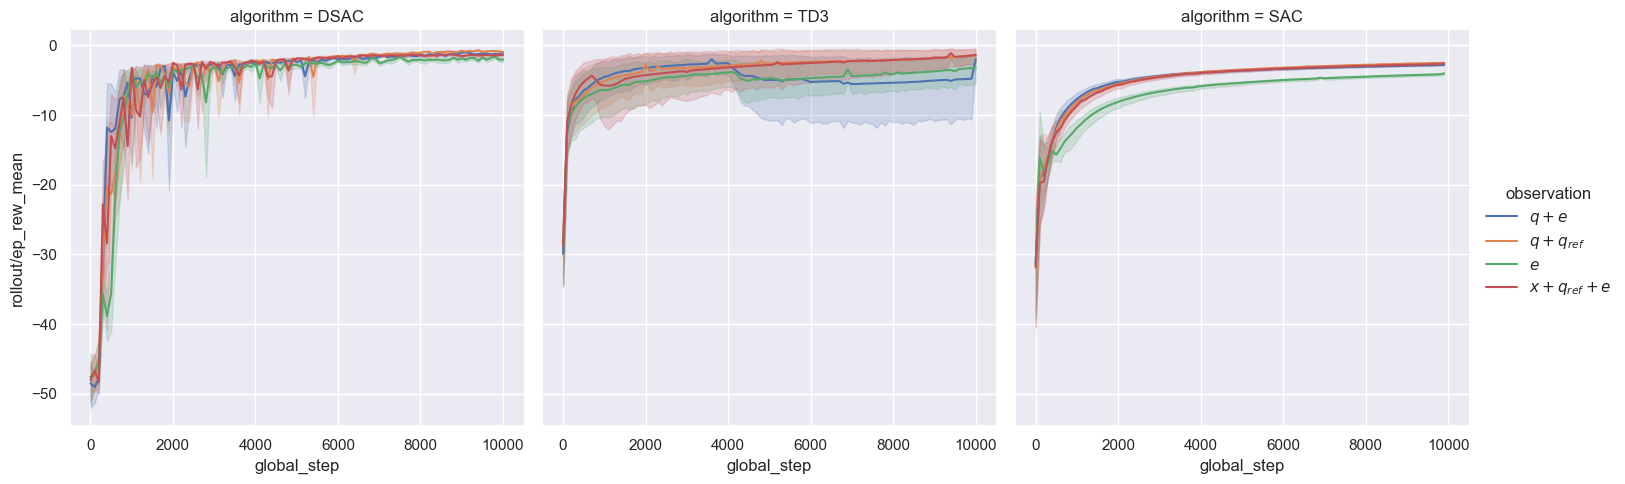

In [5]:
g = sns.relplot(data=df_learn_smooth, x="global_step", y="rollout/ep_rew_mean", hue="observation", kind="line", col="algorithm")

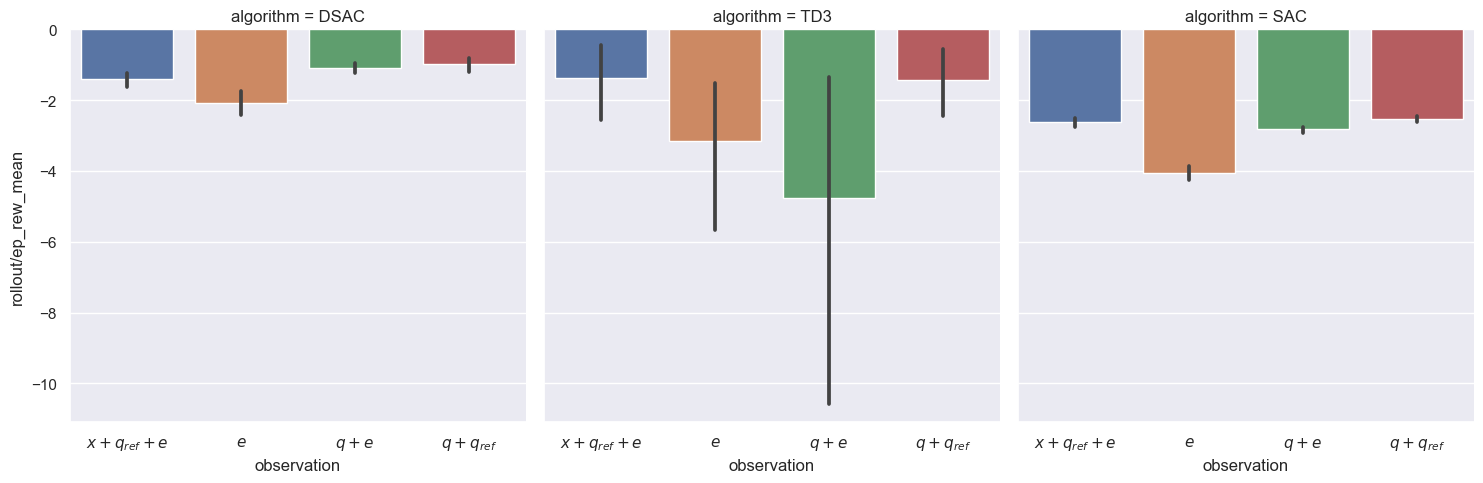

In [8]:
convergence_id = df_learn.groupby(["run"])["global_step"].idxmax().values
sns.catplot(data=df_learn.iloc[convergence_id], x="observation", y="rollout/ep_rew_mean", col="algorithm", kind="bar");

Limited training time (to mention)